### BRDF Fitting
This file fits BRDF models for the Gen 2 Starlink Chassis.  


In [1]:
# Imports
import lumos.brdf.library
import lumos.brdf.tools
import lumos.conversions
import lumos.plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.ticker import StrMethodFormatter


In [3]:
def plot_fit(ax, model, brdf_file):
    """
    :param ax: plotting axis
    :param model:
    :param brdf_file:
    :return:
    """
    phi_in, theta_in, phi_out, theta_out, brdf = lumos.brdf.tools.read_brdf(brdf_file)

    incident_angles = np.unique(phi_in)
    for angle in incident_angles:
        # Plot measured data
        ax.semilogy(phi_out[phi_in == angle], brdf[phi_in == angle], 
                    '.', label = r"$\phi_{in}$ = " + f"{angle:0.1f}°")
        
        # Plot model data
        x = np.linspace(-90, 90, 400)
        ix, iy, iz = lumos.conversions.spherical_to_unit(np.deg2rad(angle), np.pi)
        ox, oy, oz = lumos.conversions.spherical_to_unit(np.deg2rad(x), 0)
        y = model((ix, iy, iz), (0, 0, 1), (ox, oy, oz))
        ax.semilogy(x, y, '-k')
    
    for angle in (10, 20, 30, 40, 50, 60, 70, 80):
        # Plot model data at intermediate angles
        # to show there is no overfitting
        x = np.linspace(-90, 90, 400)
        ix, iy, iz = lumos.conversions.spherical_to_unit(np.deg2rad(angle), np.pi)
        ox, oy, oz = lumos.conversions.spherical_to_unit(np.deg2rad(x), 0)
        y = model((ix, iy, iz), (0, 0, 1), (ox, oy, oz))
        ax.semilogy(x, y, '--k', alpha = 0.25)

In [4]:
def BRDF_2D(polar_ax, brdf_model, incident_angle):
    """
    Plots the BRDF at given incident angle.

    :param ax: Plotting axis. Must have polar projection.
    :type ax: :class:`matplotlib.axes.Axes`
    :param brdf_model: BRDF function to plot
    :type brdf_model: function
    :param incident_angle: Incident angle for which to plot BRDF model (degrees)
    :type incident_angle: float
    """
    phi_out = np.linspace(0, 90, 180)
    theta_out = np.linspace(0, 360, 360)
    phi_out, theta_out = np.meshgrid(phi_out, theta_out)

    ix, iy, iz = lumos.conversions.spherical_to_unit(np.deg2rad(incident_angle), np.pi)
    ox, oy, oz = lumos.conversions.spherical_to_unit(np.deg2rad(phi_out), np.deg2rad(theta_out))
    y = brdf_model((ix, iy, iz), (0, 0, 1), (ox, oy, oz))
    contours_plot = polar_ax.contourf(np.deg2rad(theta_out), phi_out, np.log10(y))
    polar_ax.set_title(r"$\phi_{in}$ = " + f"{incident_angle:0.1f}°")
    polar_ax.set_xticks([])
    polar_ax.set_yticks([])
    polar_ax.set_theta_zero_location('N')
    return contours_plot

In [5]:
def binomial_fit(brdf_file, n, m, l1, l2, d):
    N_params = n * m + n * (l2 - l1)

    def model(*params):
        B, C = lumos.brdf.tools.pack_binomial_parameters(n, m, l1, l2, *params)
        brdf = lumos.brdf.library.BINOMIAL(B, C, d, l1)
        return brdf
    
    optimal_params = lumos.brdf.tools.fit(
        brdf_file,
        model,
        bounds = (-1e4, 1e4),
        p0 = -1 * np.ones(N_params),
        clip = 1e-4)
    
    B, C = lumos.brdf.tools.pack_binomial_parameters(n, m, l1, l2, *optimal_params)
    return B, C

In [6]:
def lambertian_fit(brdf_file):
    def model(albedo):
        brdf = lumos.brdf.library.LAMBERTIAN(albedo)
        return brdf
    
    optimal_params = lumos.brdf.tools.fit(
        brdf_file,
        model,
        bounds=(0,1),
        p0 = np.array([0.5]),
        clip = 1e-3
    )
    
    return optimal_params[0]

In [7]:
def abg_fit(brdf_file):
    def model(a,b,g):
        brdf = lumos.brdf.library.ABG(a,b,g)
        return brdf

    optimal_params = lumos.brdf.tools.fit(
        brdf_file,
        model,
        bounds=(0,10),
        p0 = np.array([1,1,1]),
        clip = 1e-3
    )

    return optimal_params

In [8]:
def phong_fit_tool(
        data_file,
        model_func,
        bounds = None,
        p0 = None,
        log_space = True,
        clip = 0
):

    """
    Fits a model to experimental data.

    :param data_file: A path to a .csv file containing BRDF data. DESCRIBE FORMAT.
    :type data_file: str
    :param model_func: A BRDF model to fit
    :type model_func: function
    :param bounds: Bounds passed to :py:func:`scipy.optimize.curve_fit`
    :type bounds: tuple
    :param p0: Initial guess for parameters passed to :py:func:`scipy.optimize.curve_fit`
    :type p0: tuple
    :param log_space: Whether or not to fit BRDF in log_space
    :type log_space: bool
    :param clip: Removes BRDF data below this cutoff from fitting
    :type clip: float
    """

    phi_in, theta_in, phi_out, theta_out, brdf = lumos.brdf.tools.read_brdf(data_file)
    phi_in, theta_in = np.deg2rad(phi_in), np.deg2rad(theta_in)
    phi_out, theta_out = np.deg2rad(phi_out), np.deg2rad(theta_out)

    mask = brdf > clip

    phi_in = phi_in[mask]
    
    theta_in = theta_in[mask]
    phi_out = phi_out[mask]
    theta_out = theta_out[mask]
    brdf = brdf[mask]

    indexes = np.arange(brdf.size)

    ix, iy, iz = lumos.conversions.spherical_to_unit(phi_in, theta_in)
    ox, oy, oz = lumos.conversions.spherical_to_unit(phi_out, theta_out)

    def constraint_sum1(params):
        return 1 - (params[0] + params[1])

    constraints = ({'type': 'ineq', 'fun': constraint_sum1})
    def fit_function(idx, *params):
        model_brdf = model_func(*params)

        idx = idx.astype(int)

        f = model_brdf(
            (ix[idx], iy[idx], iz[idx]),
            (0, 0, 1),
            (ox[idx], oy[idx], oz[idx])
        )

        return np.log10(f) if log_space else f
    
    popt, _ = scipy.optimize.curve_fit(fit_function,
                                       indexes,
                                       np.log10(brdf) if log_space else brdf,
                                       bounds = bounds,
                                       p0 = p0)
    

    return popt

In [9]:
def phong_optimize(brdf_file, clip):

    phi_in, theta_in, phi_out, theta_out, brdf = lumos.brdf.tools.read_brdf(brdf_file)
    phi_in, theta_in = np.deg2rad(phi_in), np.deg2rad(theta_in)
    phi_out, theta_out = np.deg2rad(phi_out), np.deg2rad(theta_out)

    mask = brdf > clip

    phi_in = phi_in[mask]
    theta_in = theta_in[mask]
    phi_out = phi_out[mask]
    theta_out = theta_out[mask]
    brdf = brdf[mask]

    ix, iy, iz = lumos.conversions.spherical_to_unit(phi_in, theta_in)
    ox, oy, oz = lumos.conversions.spherical_to_unit(phi_out, theta_out)

    def constraint_sum1(params):
        return 1 - (params[0] + params[1])

    constraints = ({'type': 'ineq', 'fun': constraint_sum1})
    
    def optimizes(params):
        p0, p1, p2 = params

        calculated_brdfs = np.zeros(len(phi_in))

        model = lumos.brdf.library.PHONG(p0, p1, p2)
        for i in range(len(phi_in)):
            calculated_brdfs[i] = model((ix[i], iy[i], iz[i]),
                                        (0,0,1),
                                        (ox[i],oy[i],oz[i]))

        # Return RMS between prediction and actual observation
        error = calculated_brdfs - brdf
        rms = np.sqrt(np.mean(error**2))
        return rms

    x0 = [0.3, 0.4, 8]
    sol = scipy.optimize.minimize(optimizes, x0, bounds=((0,1),(0,1),(0,10)), method='SLSQP', constraints=constraints)
    return sol

phong_optimize("black_c138.csv", clip = 1e-3)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.5867007669829423
       x: [ 1.002e-16  9.155e-01  1.000e+01]
     nit: 12
     jac: [ 1.207e-02 -1.788e-07 -3.851e-03]
    nfev: 48
    njev: 12

In [9]:
def phong_fit(brdf_file):
    def model(p0, p1, p2):
        brdf = lumos.brdf.library.PHONG(p0, p1, p2)
        return brdf
    
    optimal_params = phong_fit_tool(
        brdf_file,
        model,
        bounds=(0, [0.5, 0.5, 10]),
        p0 = np.array([0.3, 0.4, 7]),
        clip = 1e-3
    )
    
    return optimal_params

### Satellite surfaces

In [ ]:
# LRB50Xl2

B, C = binomial_fit("LRB50XL2.csv", n = 3, m = 2, l1 = -3, l2 = 3, d = 3.0)

print("B = np.array(", np.array2string(B, separator = ',', precision = 3),")")
print("C = np.array(", np.array2string(C, separator = ',', precision = 3),")")

LRB_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -3)


B = np.array( [[ -2.014,  3.935],
 [  0.906,-15.296],
 [ -0.196, 13.039]] )
C = np.array( [[ 1568.713,-6957.513, 4197.732,-1078.46 ,  191.648,  -29.161],
 [-7807.871, 6352.045,-4865.936, 2780.032, -896.354,  169.988],
 [10000.   ,-8481.038, 3785.344,-2006.663,  871.593, -196.501]] )


Text(0.5, 0, 'Outgoing Zenith Angle')

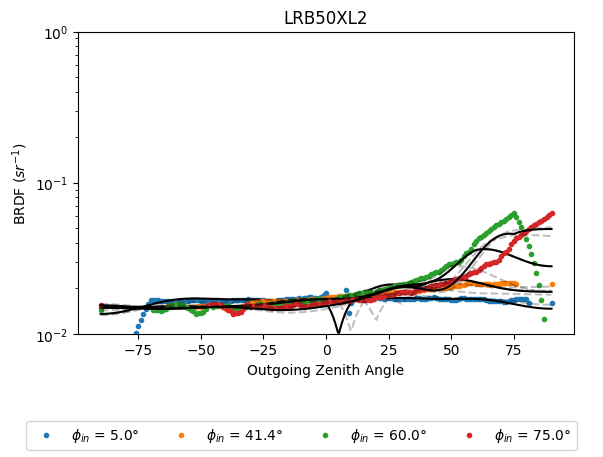

In [ ]:
fig, ax = plt.subplots()
plot_fit(ax, LRB_brdf, "LRB50XL2.csv")
ax.set_title("LRB50XL2")
ax.set_ylim(10e-3, 10e-1)
ax.set_xlabel("Outgoing zenith angle")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")

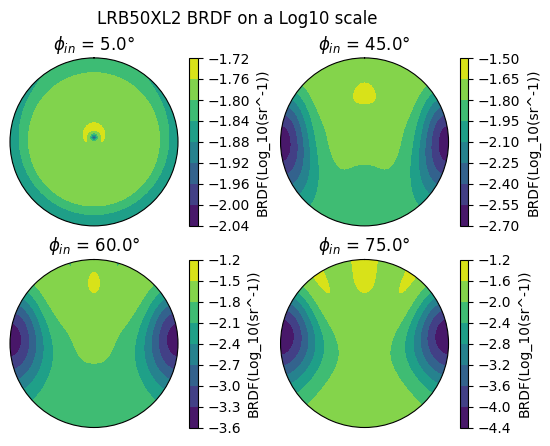

In [30]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], LRB_brdf, 5)
contour2 = BRDF_2D(axs[0,1], LRB_brdf, 45)
contour3 = BRDF_2D(axs[1,0], LRB_brdf, 60)
contour4 = BRDF_2D(axs[1,1], LRB_brdf, 75)
fig.suptitle("LRB50XL2 BRDF on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")



B = np.array( [[-0.365,-4.975]] )
C = np.array( [[1.746,5.717,6.474,1.831,4.67 ,1.163]] )


Text(0.5, 0, 'Outgoing Zenith Angle')

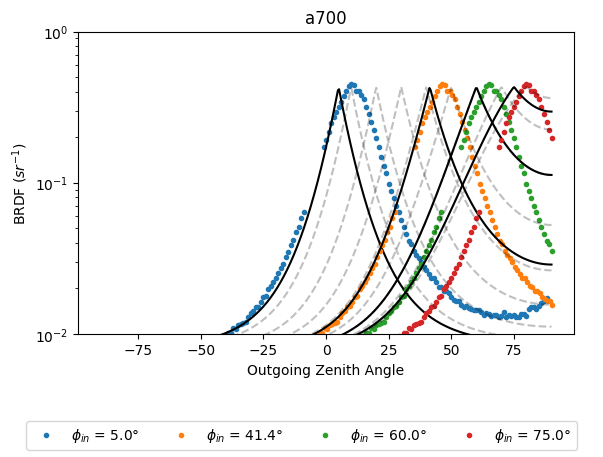

In [31]:
# A700

n = 1
m = 2
d = 1.0
l1 = -3
l2 = 3

B, C = binomial_fit("A700.csv", n = n, m = m, l1 = l1, l2 = l2, d = d)

print("B = np.array(", np.array2string(B, separator = ',', precision = 3),")")
print("C = np.array(", np.array2string(C, separator = ',', precision = 3),")")

A700_brdf = lumos.brdf.library.BINOMIAL(B, C, d = d, l1 = l1)

fig, ax = plt.subplots()
plot_fit(ax, A700_brdf, "A700.csv")
ax.set_title("a700")
ax.set_ylim(10e-3, 10e-1)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing zenith angle")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")

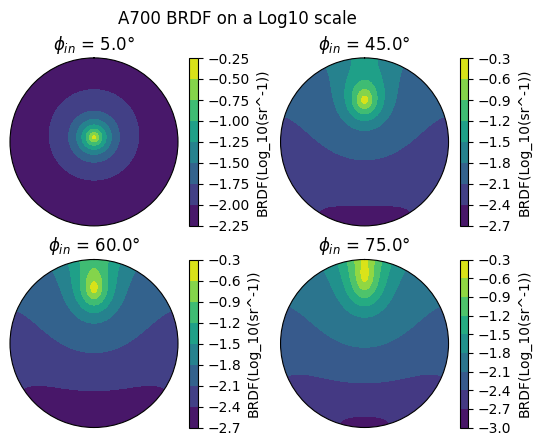

In [32]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], A700_brdf, 5)
contour2 = BRDF_2D(axs[0,1], A700_brdf, 45)
contour3 = BRDF_2D(axs[1,0], A700_brdf, 60)
contour4 = BRDF_2D(axs[1,1], A700_brdf, 75)
fig.suptitle("A700 BRDF on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

In [35]:
# Chassis bare 
B, C = binomial_fit("chassis_bare.csv", n = 1, m = 2, l1 = -3, l2 = 3, d = 3.0)

print("B = ", np.array2string(B, separator=',', precision = 3))
print("C = ", np.array2string(C, separator=',', precision = 3))

chassis_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -3)

B =  [[  3.328,-39.368]]
C =  [[-10000.   ,  8714.252, -3292.682,  1071.191,  -307.512,   102.215]]


Text(0.5, 0, 'Outgoing Zenith Angle')

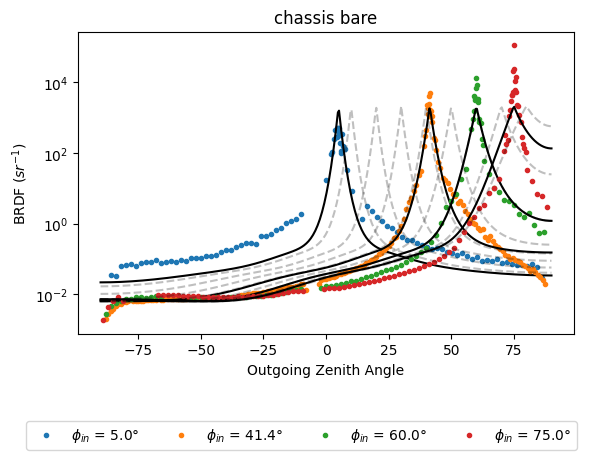

In [36]:
fig, ax = plt.subplots()
plot_fit(ax, chassis_brdf, "chassis_bare.csv")
ax.set_title("chassis bare")
ax.set_ylim()
ax.set_xlabel("Outgoing zenith angle")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")


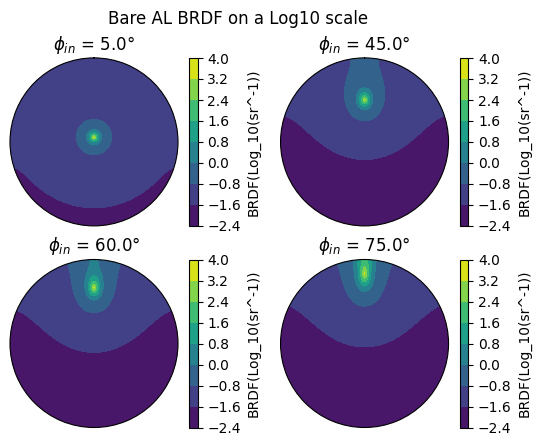

In [37]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], chassis_brdf, 5)
contour2 = BRDF_2D(axs[0,1], chassis_brdf, 45)
contour3 = BRDF_2D(axs[1,0], chassis_brdf, 60)
contour4 = BRDF_2D(axs[1,1], chassis_brdf, 75)
fig.suptitle("Bare AL BRDF on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

0.019989862079564824
2.2851243807209376e-06
2.2640286229702555


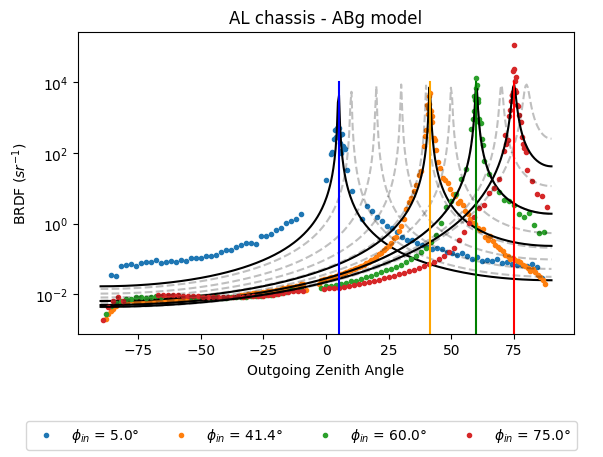

In [46]:
a,b,g = abg_fit("chassis_bare.csv")
print(a)
print(b)
print(g)

chassis_abg_brdf = lumos.brdf.library.ABG(a,b,g)
#chassis_abg_brdf = lumos.brdf.library.LAMBERTIAN(0)
fig, ax = plt.subplots()
plot_fit(ax,chassis_abg_brdf, "chassis_bare.csv")
ax.set_title("AL chassis - ABg model")
ax.set_ylim()


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")

ax.plot(5*np.ones(len(np.linspace(0,10000))),np.linspace(0,10000), c='blue')
ax.plot(41.4*np.ones(len(np.linspace(0,10000))),np.linspace(0,10000), c='orange')
ax.plot(60*np.ones(len(np.linspace(0,10000))),np.linspace(0,10000), c='green')
ax.plot(75*np.ones(len(np.linspace(0,10000))),np.linspace(0,10000), c='red')

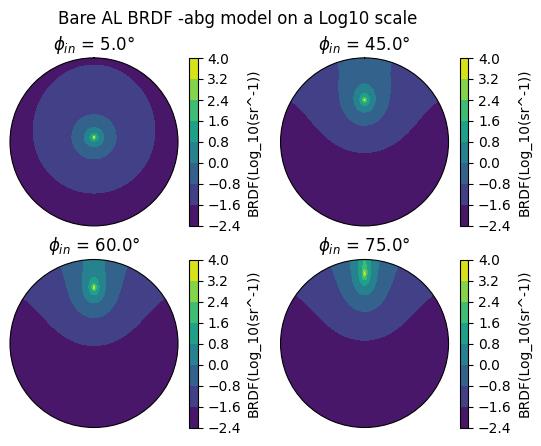

In [38]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], chassis_abg_brdf, 5)
contour2 = BRDF_2D(axs[0,1], chassis_abg_brdf, 45)
contour3 = BRDF_2D(axs[1,0], chassis_abg_brdf, 60)
contour4 = BRDF_2D(axs[1,1], chassis_abg_brdf, 75)
fig.suptitle("Bare AL BRDF -abg model on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

In [16]:
# blackc138
B, C = binomial_fit("black_c138.csv", n = 3, m = 3, l1 = -5, l2 = 5, d = 3.0)
#B, C = binomial_fit("../data/chassis_brdf.csv", n = 1, m = 2, l1 = -5, l2 = 5, d = 3.0)
print("B = ", np.array2string(B, separator=',', precision = 3))
print("C = ", np.array2string(C, separator=',', precision = 3))

blackc138_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -5)


B =  [[-1.469e+00, 2.427e-01,-1.056e+02],
 [-2.304e+00,-1.378e+00, 2.609e+02],
 [ 5.110e+00, 1.867e+00,-8.702e+01]]
C =  [[ 6.166e+02, 1.031e+03, 2.440e+03, 3.314e+03, 9.210e+02,-4.645e+02,
   7.986e+01,-1.486e+01, 5.398e+00,-1.858e+00],
 [-3.179e+03,-3.820e+03,-6.938e+03,-8.441e+03,-7.682e+03, 6.689e+03,
  -3.037e+03, 1.228e+03,-4.365e+02, 9.608e+01],
 [ 4.019e+03, 6.428e+03, 9.376e+03, 1.000e+04,-4.288e+03,-2.294e+03,
   2.789e+03,-1.585e+03, 6.283e+02,-1.414e+02]]


Text(0.5, 0, 'Outgoing Zenith Angle')

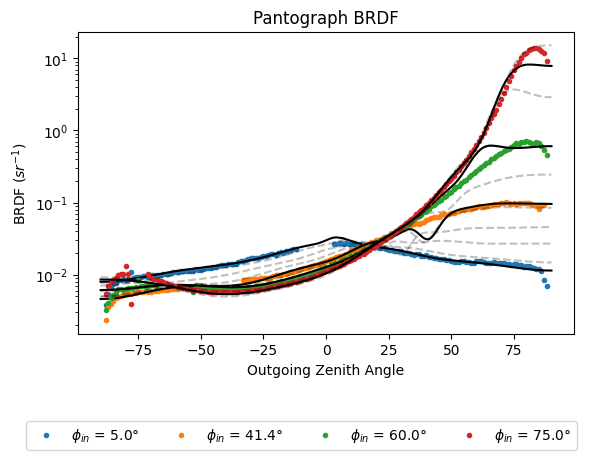

In [17]:
fig, ax = plt.subplots()
plot_fit(ax, blackc138_brdf, "black_c138.csv")
#plot_fit(ax, lumos.brdf.library.LAMBERTIAN(1), "black_c138.csv")
ax.set_title("Pantograph BRDF")
ax.set_ylim()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")



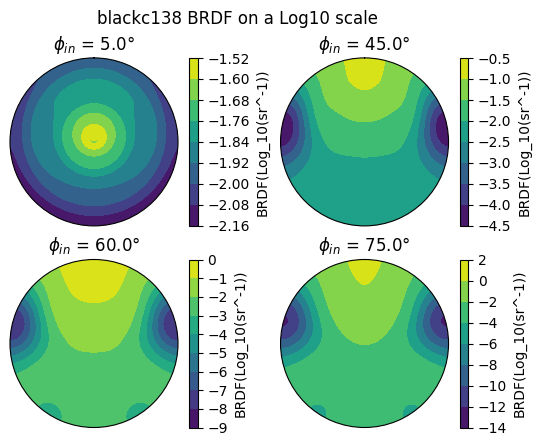

In [14]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], blackc138_brdf, 5)
contour2 = BRDF_2D(axs[0,1], blackc138_brdf, 45)
contour3 = BRDF_2D(axs[1,0], blackc138_brdf, 60)
contour4 = BRDF_2D(axs[1,1], blackc138_brdf, 75)
fig.suptitle("blackc138 BRDF on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

B =  [[  1.078 -32.658]]
C =  [[10000.    -6040.756  1392.37    -69.043   -52.863    52.601]]


Text(0.5, 0, 'Outgoing Zenith Angle')

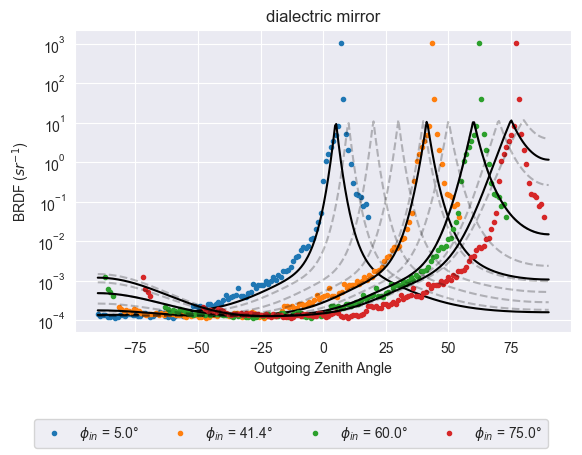

In [ ]:
# gen2 mirror
B, C = binomial_fit("gen2_dialectric_mirror.csv", n = 1, m = 2, l1 = -3, l2 = 3, d = 3.0)
print("B = ", np.array_str(B, precision = 3))
print("C = ", np.array_str(C, precision = 3))

mirror_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -3)

fig, ax = plt.subplots()
plot_fit(ax,mirror_brdf, "gen2_dialectric_mirror.csv")
ax.set_title("dialectric mirror")
ax.set_ylim()


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")




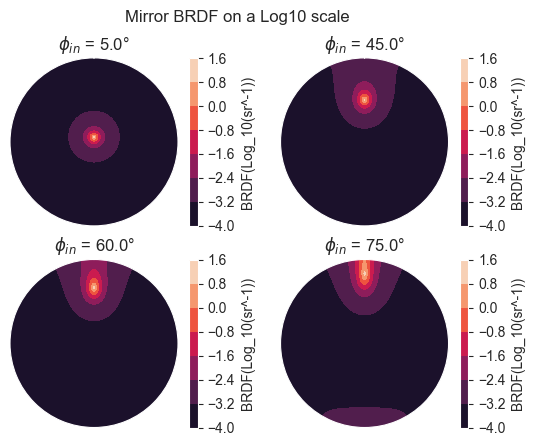

In [ ]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], mirror_brdf, 5)
contour2 = BRDF_2D(axs[0,1], mirror_brdf, 45)
contour3 = BRDF_2D(axs[1,0], mirror_brdf, 60)
contour4 = BRDF_2D(axs[1,1], mirror_brdf, 75)
fig.suptitle("Mirror BRDF on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

9.737640136103837e-05
8.4487260900977e-06
2.6865010547434456


Text(0.5, 0, 'Outgoing Zenith Angle')

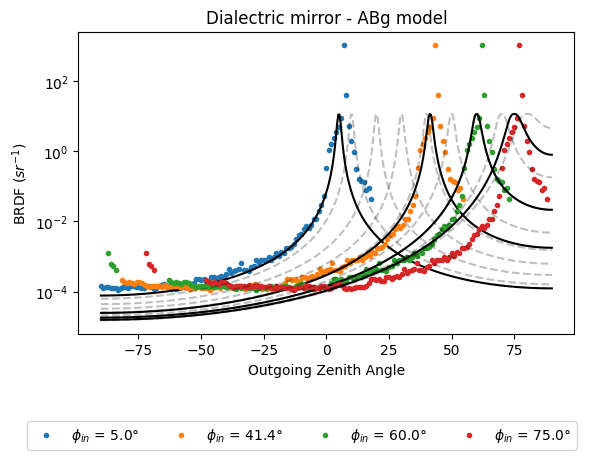

In [ ]:
a,b,g = abg_fit("gen2_dialectric_mirror.csv")
print(a)
print(b)
print(g)

mirror_abg_brdf = lumos.brdf.library.ABG(a,b,g)

fig, ax = plt.subplots()
plot_fit(ax,mirror_abg_brdf, "gen2_dialectric_mirror.csv")
ax.set_title("Dialectric mirror - ABg model")
ax.set_ylim()


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)
ax.set_ylabel(r"BRDF ($sr^{-1}$)")
ax.set_xlabel("Outgoing Zenith Angle")

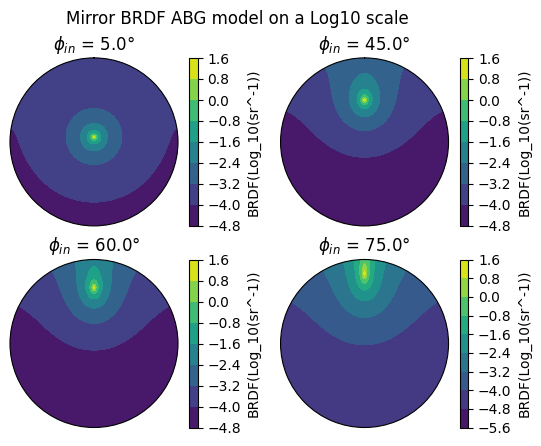

In [ ]:
fig, axs = plt.subplots(2, 2,subplot_kw={'projection': 'polar'})
contour1 = BRDF_2D(axs[0,0], mirror_abg_brdf, 5)
contour2 = BRDF_2D(axs[0,1], mirror_abg_brdf, 45)
contour3 = BRDF_2D(axs[1,0], mirror_abg_brdf, 60)
contour4 = BRDF_2D(axs[1,1], mirror_abg_brdf, 75)
fig.suptitle("Mirror BRDF ABG model on a Log10 scale")

cbar1 = fig.colorbar(contour1, ax=axs[0, 0])
cbar1.set_label("BRDF(Log_10(sr^-1))")
cbar2 = fig.colorbar(contour2, ax=axs[0, 1])
cbar2.set_label("BRDF(Log_10(sr^-1))")
cbar3 = fig.colorbar(contour3, ax=axs[1, 0])
cbar3.set_label("BRDF(Log_10(sr^-1))")
cbar4 = fig.colorbar(contour4, ax=axs[1, 1])
cbar4.set_label("BRDF(Log_10(sr^-1))")

In [ ]:
fig, axs = plt.subplots(figsize = (8.5, 4), nrows = 2, ncols = 1, sharex = True, dpi = 400)

plot_fit(axs[0], chassis_brdf, "../data/chassis_brdf.csv")
axs[0].set_title("Chassis Deck")

plot_fit(axs[1], solar_array_brdf, "../data/solar_array_brdf.csv")
axs[1].set_title("Solar Array")

for ax in axs:
    ax.set_ylim(10e-4, 10e4)
    ax.set_ylabel(r"BRDF ($sr^{-1}$)")

axs[1].set_xlabel("Outgoing Zenith Angle")
axs[1].set_xticks([-90, -60, -30, 0, 30, 60, 90])
axs[1].xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)

plt.show()

In [ ]:
fig, ax = plt.subplots()
plot_fit(ax, LRB_brdf, "LRB50XL2.csv")
ax.set_title("LRB50XL2")
ax.set_ylim(10e-3, 10e-1)